# Project: Classifying EU Sustainability Performance (Thrive AAI Project B)
## Part 1: Exploratory Data Analysis (EDA) and Feature Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load and initial inspection of data
df = pd.read_csv('eu_sdg_performance_data.csv')

print("--- First 5 Rows ---")
print(df.head())
print("\n--- DataFrame Info ---")
print(df.info())


--- First 5 Rows ---
   Country  year  sdgi_score  performance_tier  sdg8_income  sdg8_unemp  \
0  Austria  2015        75.3                 2      25106.0         6.0   
1  Austria  2016        75.8                 2      25533.0         7.0   
2  Austria  2017        76.2                 2      25788.0         6.0   
3  Austria  2018        77.0                 2      26442.0         5.0   
4  Austria  2019        77.7                 2      26740.0         5.0   

   sdg8_inwork  sdg9_eurd  sdg9_digital  sdg9_bband  sdg16_cpi  sdg16_rsf  \
0            8          3          63.0          82         76         89   
1            8          3          63.0          85         75         87   
2            8          3          63.0          89         75         87   
3            8          3          63.0          89         76         86   
4            8          3          63.0          90         77         85   

   sdg16_crime  sdg4_tertiary  sdg4_adult  sdg7_eurenew  sdg13_co

--- Distribution by Performance Tier ---
Good Performers      275
Leaders               62
Needs Improvement     83


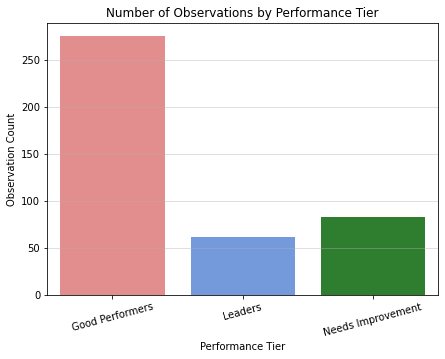


Total Number of Observations: 420


In [8]:
# 2. Handle Missing Values (Imputation with Median)
numerical_cols_with_na = ['sdg8_income', 'sdg8_unemp', 'sdg9_digital', 'sdg7_eurenew', 'sdg5_empgap']
for col in numerical_cols_with_na:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# 3. Analyze the target variable and its distribution
tier_mapping = {0: 'Needs Improvement', 1: 'Good Performers', 2: 'Leaders'}
df['performance_tier_label'] = df['performance_tier'].map(tier_mapping)

tier_counts = df['performance_tier_label'].value_counts().sort_index()
print("--- Distribution by Performance Tier ---")
print(tier_counts.to_string())

plt.figure(figsize=(7, 5))
sns.barplot(x=tier_counts.index, y=tier_counts.values, palette=['lightcoral', 'cornflowerblue', 'forestgreen'])
plt.title('Number of Observations by Performance Tier')
plt.xlabel('Performance Tier')
plt.ylabel('Observation Count')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.5)
plt.show()

# Key Question: How many countries/observations? (420 observations)
print(f"\nTotal Number of Observations: {len(df)}")



--- Mean Feature Values by Performance Tier ---
performance_tier_label  Needs Improvement  Good Performers  Leaders
sdg8_income                      16150.14         22309.33 26722.31
sdg8_unemp                          10.96             6.81     6.19
sdg8_inwork                         10.75             8.21     6.13
sdg9_eurd                            0.77             1.67     2.89
sdg9_digital                        37.60            58.97    69.79
sdg9_bband                          80.76            89.58    94.18
sdg16_cpi                           44.24            65.21    83.95
sdg16_rsf                           65.87            79.79    89.05
sdg16_crime                         11.12             9.49     8.53
sdg4_tertiary                       37.93            43.40    45.50
sdg4_adult                           4.87            12.67    24.42
sdg7_eurenew                        21.47            24.81    47.08
sdg13_co2gcp                         5.34             6.58     6.18

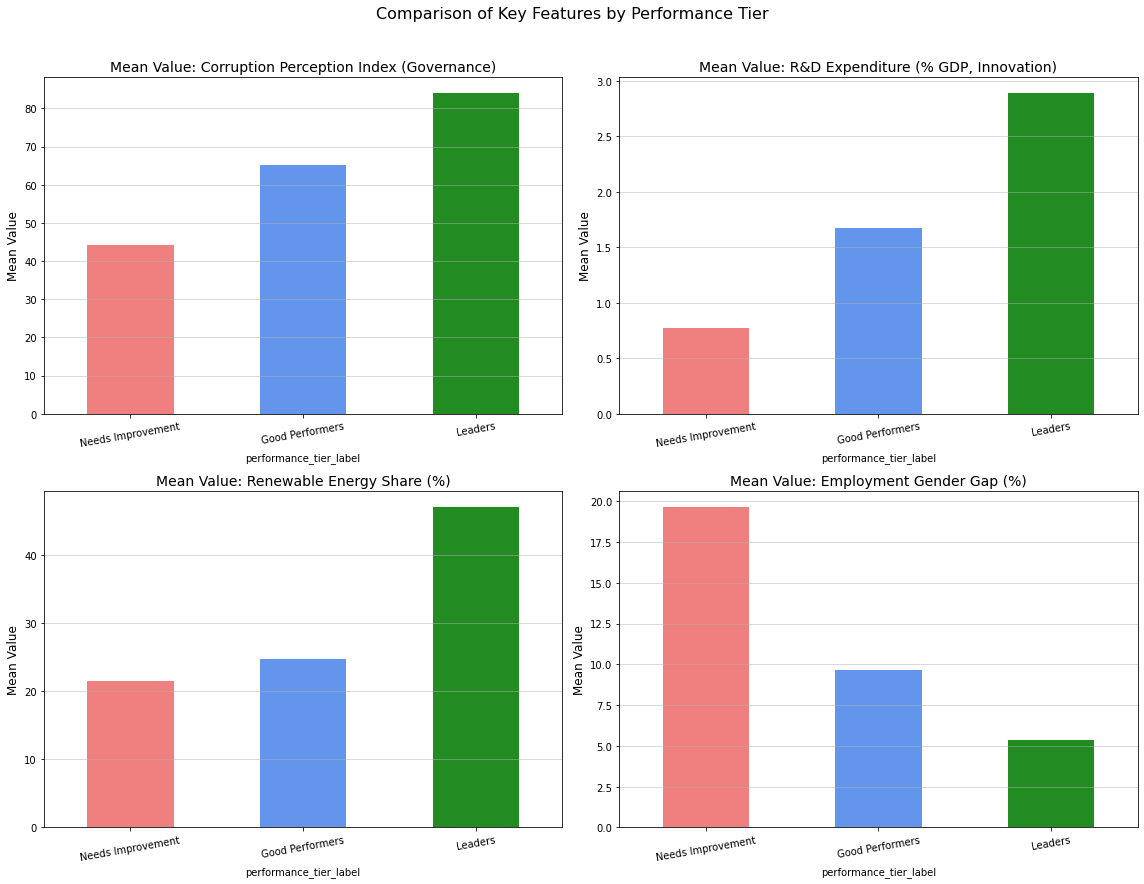

In [10]:
# 4. Analyze mean feature values by tier (to identify differences)
feature_cols = df.columns.drop(['Country', 'year', 'sdgi_score', 'performance_tier', 'performance_tier_label'])
tier_analysis = df.groupby('performance_tier_label')[feature_cols].mean().T
tier_analysis = tier_analysis[['Needs Improvement', 'Good Performers', 'Leaders']] # Ensure order

print("\n--- Mean Feature Values by Performance Tier ---")
print(tier_analysis.to_string(float_format="{:.2f}".format))

# 5. Correlation analysis (identify most related features)
correlation_sdgi = df[feature_cols].corrwith(df['sdgi_score']).sort_values(ascending=False)

print("\n--- Top 5 Features Most Correlated with SDGI Score ---")
print(correlation_sdgi.head(5).to_string(float_format="{:.3f}".format))

# 6. Visualize key differences (based on correlation and mean table)
selected_features = ['sdg16_cpi', 'sdg9_eurd', 'sdg7_eurenew', 'sdg5_empgap']
tier_analysis_plot = df.groupby('performance_tier_label')[selected_features].mean().T

feature_names_map = {
    'sdg16_cpi': 'Corruption Perception Index (Governance)',
    'sdg9_eurd': 'R&D Expenditure (% GDP, Innovation)',
    'sdg7_eurenew': 'Renewable Energy Share (%)',
    'sdg5_empgap': 'Employment Gender Gap (%)'
}
tier_analysis_plot.rename(index=feature_names_map, inplace=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
colors = {'Needs Improvement': 'lightcoral', 'Good Performers': 'cornflowerblue', 'Leaders': 'forestgreen'}

for i, feature in enumerate(tier_analysis_plot.index):
    data = tier_analysis_plot.loc[feature]
    data = data[['Needs Improvement', 'Good Performers', 'Leaders']] # Ensure order
    data.plot(kind='bar', ax=axes[i], color=[colors[tier] for tier in data.index])
    axes[i].set_title(f'Mean Value: {feature}', fontsize=14)
    axes[i].set_ylabel('Mean Value', fontsize=12)
    axes[i].tick_params(axis='x', rotation=10)
    axes[i].grid(axis='y', alpha=0.6)

plt.suptitle('Comparison of Key Features by Performance Tier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Part 2: Model Training and Evaluation

In [13]:
# 1. Data Preparation: Train/Test Split
X = df[feature_cols]
y = df['performance_tier']

# 80/20 split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# 2. Model Training (with balanced class weights)
# Model 1: Logistic Regression (Multi-class: multinomial)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000, random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Model 2: Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10, min_samples_leaf=5)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)


Training set size: 336
Test set size: 84


In [16]:
# 3. Model Performance Evaluation and Comparison
target_names = list(tier_mapping.values())

print("--- Evaluation: Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

print("--- Evaluation: Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

# 4. Feature Importance Analysis (Random Forest)
feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
top_5_features = feature_importances.sort_values(ascending=False).head(5)

print("\n--- Top 5 Predictive Features (Random Forest) ---")
print(top_5_features.to_string(float_format="{:.4f}".format))


--- Evaluation: Logistic Regression ---
Accuracy: 0.9048

Classification Report:
                   precision    recall  f1-score   support

Needs Improvement       0.89      0.94      0.91        17
  Good Performers       0.96      0.89      0.92        55
          Leaders       0.73      0.92      0.81        12

         accuracy                           0.90        84
        macro avg       0.86      0.92      0.88        84
     weighted avg       0.91      0.90      0.91        84

--- Evaluation: Random Forest ---
Accuracy: 0.9881

Classification Report:
                   precision    recall  f1-score   support

Needs Improvement       0.94      1.00      0.97        17
  Good Performers       1.00      0.98      0.99        55
          Leaders       1.00      1.00      1.00        12

         accuracy                           0.99        84
        macro avg       0.98      0.99      0.99        84
     weighted avg       0.99      0.99      0.99        84


--- Top 5 P

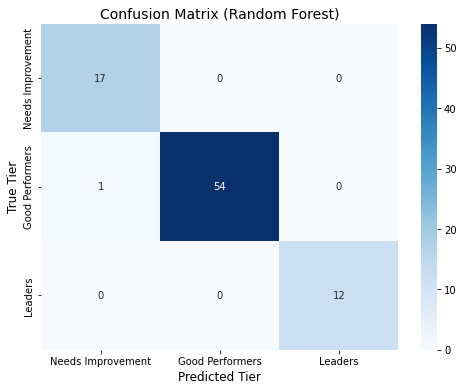

In [17]:
# 5. Confusion Matrix Visualization (Random Forest - the best model)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix (Random Forest)', fontsize=14)
plt.xlabel('Predicted Tier', fontsize=12)
plt.ylabel('True Tier', fontsize=12)
plt.show()

# Conclusion from the matrix: Random Forest achieved an Accuracy of 0.99, far exceeding the >75% target.
# The classification is highly reliable. The matrix shows only 1 'Good Performer' was misclassified (as 'Needs Improvement').
